## Solving a simple Poisson-Problem

In this notebook, we use all previously learned concepts and present the structure of the learning process.

We still want to solve the equation:
$$
    \Delta u = -4.25\pi^2 u, \text{ in } \Omega = [0, 1] \times [0, 1],
$$
$$
    u(x) = \sin(\tfrac{\pi}{2} x_1)\cdot \cos(2\pi x_2), \text{ on } \partial \Omega.
$$
Before we start we import _PyTorch_ and _PyTorch Lightning_, which will handle the trainig process. Also we select a possible GPU (to make the trainig process faster)

In [1]:
import torch
import numpy as np
import pytorch_lightning as pl

os.environ["CUDA_VISIBLE_DEVICES"] = "4" # select GPUs to use

torch.cuda.is_available()

True

Now we create all the previous shown instances.

In [2]:
# create the space-varibale x, just like before:
from torchphysics.problem.variables import Variable
from torchphysics.problem.domain import Rectangle

x = Variable(name='x',
             order=2,
             domain=Rectangle(corner_dl=[0, 0],
                              corner_dr=[1, 0],
                              corner_tl=[0, 1]),
             train_conditions={},
             val_conditions={})

In [3]:
# Next are the condition:
from torchphysics.utils.differentialoperators import laplacian
from torchphysics.problem.condition import DiffEqCondition, DirichletCondition

# PDE-condition:
def pde_function(u, input):
    return laplacian(u, input['x']) +  4.25*np.pi**2*u

pde_cond = DiffEqCondition(pde=pde_function, 
                           norm=torch.nn.MSELoss(), 
                           name='test_pde', 
                           sampling_strategy='grid',
                           dataset_size=500)

# Boundary-condition:
def bound_function(input): 
    return np.sin(np.pi/2*input['x'][:, :1])*np.cos(2*np.pi*input['x'][:, 1:])

diri_cond = DirichletCondition(dirichlet_fun=bound_function,
                               name='test diri',
                               boundary_sampling_strategy='grid',
                               norm=torch.nn.MSELoss(),
                               weight=1.0,
                               dataset_size=200)

In [4]:
# Add the boundary condition to x:
x.add_train_condition(diri_cond)

Now we have the first new step. In general, we would have different variables and more conditions, maybe even some validation condition. To collect all of this, we define a _Setting_. Here we finally use the inner PDE-condition. 

The _Setting_ is a subclass of the LightningDataModule and will be later given to the LightningTrainer.

In [5]:
from torchphysics.setting import Setting

setup = Setting(variables=(x), # tuple/list of all variables 
                train_conditions={'pde': pde_cond}, # our pde
                val_conditions={}, # here no validation
                n_iterations=500) # number of steps per epoch

Next is one of the most important steps, defining the neural network. For this, different models are implemented, that can be found under _torchphysics.models_.

Here we use a simple fully connected network.

In [6]:
from torchphysics.models.fcn import SimpleFCN

model=SimpleFCN(input_dim=2, depth=2, width=20)

The last step, before we can start training, is to create an instance of _PINNModule_. This class handles the training and validation. We dont need to write our own training loops.

Here we define the optimizer, learning rate and possible a scheduler to change/adjust the learning rate. All imported from _PyTorch_.

Since we use _PyTorch Lightning_ we can also use tensorboard to check our training progress and even create a _Plotter_ to show the solution while training. 

In [7]:
from torchphysics import PINNModule

solver = PINNModule(model=model, # the network
                    optimizer=torch.optim.Adam,
                    lr=1e-2)

Finally, we can define a lightning trainer and train the model:

In [8]:
trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_epochs=2,
                     logger=False,
                     checkpoint_callback=False)

trainer.fit(solver, setup)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 921   
------------------------------------
921       Trainable params
0         Non-trainable params
921       Total params
0.004     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Once the loss is small it is sometimes usefull to switch to LBFGS, for some additional steps, or to use a scheduler.

In [9]:
solver.optimizer = torch.optim.LBFGS
solver.lr = 1
solver.optim_params = {'max_iter' : 2}

trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_epochs=2,
                     logger=False,
                     checkpoint_callback=False)

trainer.fit(solver, setup)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 921   
------------------------------------
921       Trainable params
0         Non-trainable params
921       Total params
0.004     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

We trained only for four epochs (2000 iterations). This loss is further decreasing, but this should be enough for now. 

To show the solution, different helper functions are implemented in torchphysics.utils. We plot the solution:

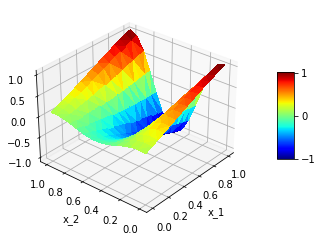

In [10]:
from torchphysics.utils.plot import _plot
fig = _plot(model=solver.model, plot_variables=x, points=200, angle=[30, 220])

These are the basics on how to use the library to solve a PDE. There are more
things for what this library, for example an inverse problem. 

There are now different possibilities to do what next, either try to solve your first own problem, change this notebook and try out different things,or check out the other examples.  Especially the heat_equation-ordner has many different applications with some helpful explanations.

